# Example notebook for CIFAR image classification training

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from utils import class_accuracy
from torch.utils.tensorboard import SummaryWriter

from data_utils import read_data_sets

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel


/Users/weibinchen/miniforge3/envs/torch-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training function

In [3]:
import time
from tqdm import tqdm

def train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device='cuda'):
    st = time.time()
    eval_time = 0

    for epoch in range(1, epochs + 1):
        with tqdm(train_loader, unit="batch") as tepoch:
            running_loss = 0
            running_acc = 0
            for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
                tepoch.set_description(f"Epoch {epoch}")

                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                opt.zero_grad()
                output = model(batch_data)

                loss = likelihood(output, batch_labels)

                running_loss += loss.item()
                running_acc += class_accuracy(output, batch_labels).item()

                loss.backward()
                opt.step()

                et = time.time()
                if n % 50 == 0:
                    model.eval()

                    running_test_loss = 0
                    running_test_acc = 0

                    for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                        test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                        test_output = model(test_batch_data)

                        test_loss = likelihood(test_output, test_batch_labels)

                        running_test_loss += test_loss.item()
                        running_test_acc += class_accuracy(test_output, test_batch_labels).item()

                    running_test_loss /= m
                    running_test_acc /= m

                    tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                    model.train()
                    eval_time += time.time() - et

            epoch_time = time.time() - st - eval_time
            tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

    return model


# Reading in CIFAR data

In [4]:
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=False, reshape=False)

Begin loading data for MNIST
Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


In [5]:
## Dataset
train_dataset = dataset.train
test_dataset = dataset.test

print("Train size: ", train_dataset.num_examples)
print("Test size: ", test_dataset.num_examples)
print("Image shape: ", train_dataset.images.shape[1:])

Train size:  60000
Test size:  10000
Image shape:  (1, 28, 28)


In [16]:
def plot_images(dataset, n_images):
    fig, ax = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i in range(n_images):
        ax[i].imshow(dataset.images[i].reshape(28, 28), cmap="gray")
        ax[i].axis("off")
        label_one_hot = train_dataset.labels[i]
        label = np.argmax(label_one_hot)
        ax[i].set_title(f"Label: {label}")
    plt.show()

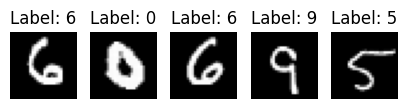

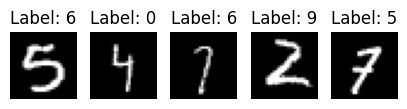

In [17]:
plot_images(train_dataset, 5)
plot_images(test_dataset, 5)

In [6]:
batch_size = 500


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [7]:

model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    # nn.Conv2d(
    #     in_channels=16,
    #     out_channels=32,
    #     kernel_size=5,
    #     stride=1,
    #     padding=2,
    # ),
    # nn.ReLU(),
    # nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 10),
)


In [8]:
model = model.to(device)


# Adam

In [9]:
likelihood = FISH_LIKELIHOODS["softmax"](device=device)

lr = 0.0005
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8

opt = optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)


trained_model = train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device=device)


  0%|          | 0/120 [00:00<?, ?batch/s]/Users/weibinchen/Desktop/UCL/PhD_Year_1/FishLeg/examples/data_utils.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._images[idx]), torch.tensor(self._labels[idx])
Epoch 2: 100%|██████████| 120/120 [00:08<00:00, 14.97batch/s, acc=91.7, test_acc=93.3]


# FishLeg

In [10]:
lr = 0.02
beta = 0.9
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 3

initialization = "normal"
normalization = True

model = initialise_FishModel(
    model, module_names="__ALL__", fish_scale=scale_factor / damping
)

opt = FishLeg(
    model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    # writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)
trained_model = train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device=device)

Epoch 2: 100%|██████████| 120/120 [00:15<00:00,  7.51batch/s, acc=95.5, test_acc=96.1]
